# Preprocess rentangle

Preprocesses the image keeping the aspect ratio of the sides, fitting it into 224x224 and padding the missing space with black colour.

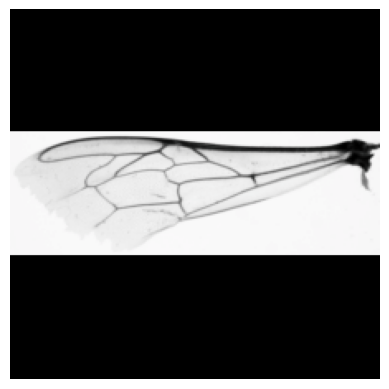

In [7]:
import numpy as np
import torch
from torchvision.io import decode_image
from torchvision.models import ViT_B_32_Weights, vit_b_32, ResNet50_Weights, resnet50

from wings.config import RAW_DATA_DIR, IMG_FOLDER_SUFX, PROCESSED_DATA_DIR, MODELS_DIR
from wings.modeling.litnet import LitNet
from wings.modeling.models import TransformerPreTrained, ResnetPreTrained
from wings.visualizing.image_preprocess import fit_rectangle_preprocess, denormalize
from wings.visualizing.visualize import visualize_coords

filename = "PL-0001-000420-R.dw.png"

country = filename.split('-', 1)[0]
imgpath = RAW_DATA_DIR / f"{country}{IMG_FOLDER_SUFX}" / filename
image = decode_image(imgpath)
image = image.repeat(3, 1, 1)
image, pad_top, pad_bottom = fit_rectangle_preprocess(image)
image = denormalize(image)

visualize_coords(image, torch.Tensor([0.]))


# Visualization from dataset with target coordinates

In [9]:
test_dataset = torch.load(PROCESSED_DATA_DIR / "rectangle_datasets" / "test_rec_dataset2.pth", weights_only=False)
# patrz komentarz w `01_visualize.ipynb'
transformer_checkpoint_path = MODELS_DIR / "transformer32-epoch=50-val_loss=10.08-rectangle_images_run2.ckpt"
resnet_checkpoint_path = MODELS_DIR / "resnet50-epoch=38-val_loss=54.04-rectangle_images_2.ckpt"

transformer_weights = ViT_B_32_Weights.DEFAULT
transf_model = TransformerPreTrained(vit_b_32, transformer_weights)

resnet_weights = ResNet50_Weights.DEFAULT
rn_model = ResnetPreTrained(resnet50, resnet_weights)

num_epochs = 60
transformer_model = LitNet.load_from_checkpoint(
    transformer_checkpoint_path,
    model=transf_model,
    num_epochs=num_epochs,
    criterion=torch.nn.MSELoss
)
transformer_model.eval()

resnet_model = LitNet.load_from_checkpoint(
    resnet_checkpoint_path,
    model=rn_model,
    num_epochs=num_epochs,
    criterion=torch.nn.MSELoss
)
resnet_model.eval()

max_n = len(test_dataset)


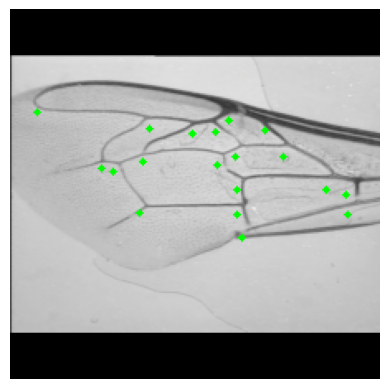

In [48]:
n = np.random.randint(0, max_n)
# image, labels = test_dataset[n]
# image = denormalize(image)
# visualize_coords(image, labels.squeeze(0), spot_size=2)

image, labels = test_dataset[n]
transformer_labels = transformer_model(image.cuda().unsqueeze(0))
image = denormalize(image)
visualize_coords(image, transformer_labels.squeeze(0), spot_size=2)

# image, labels = test_dataset[n]
# resnet_labels = resnet_model(image.cuda().unsqueeze(0))
# image = denormalize(image)
# visualize_coords(image, resnet_labels.squeeze(0), spot_size=2)